## 3.6 預測房價：回歸問題
本節將要預測Boston使用的房價的數據集，他的數據點比起前兩者較少，只有506個，分為404個訓練樣本與102個測試樣本。輸入數據的每個特徵都有不同的取值範圍；而輸入數據的每個**特徵**(比如犯罪率)都有不同的取值範圍。如：有些特徵是比例，取值範圍為0-1，以些取值範圍則是1-12等等。


In [4]:
# 3-24 加載波士頓房價數據
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape)
print(test_data.shape)

print(train_targets)        # 列出房價

###
# 如結果所示，404個訓練樣本與102個測試樣本中，
# 每個樣本都有13個數值特徵，比如人均犯罪率、高速公路可達性等
# 然而，這些房價數據沒有經過通貨膨脹進行調整
###


(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 

### 3.6.2 準備數據
將取值範圍差異很大的數據輸入到NN中，我們普遍採用的方法是對每個特徵做標準化。也就是對於輸入數據的特徵(輸入數據矩陣中的列)，減去特徵平均值，再除以標準差，如下。


In [5]:
# 3-25 數據標準化

###
# 為了將取值範圍差異極大的多類別統一當作參考
# 我們要將輸入數據標準化
###
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std


In [6]:
# 3-26 模型定義
from keras import models
from keras import layers

def build_model():              # 因為需要將同一個模型多次實例化，所以用一個函數來構建模型
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # 只有一個線性層，沒有激活函數，這是標量回歸的典型設置
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


### 利用K折驗證來驗證我們的方法 ( 適用小規模之dataset )
由於我們的數據點很少，驗證集也就非常小( 比如大約100個樣本 )，因此，驗證分數可能會有很大的波動。<br><br>

在這種情況下，我們可以使用K折驗證來彌補這點(見下圖3-11)。這種方法將可用數據化氛為K個分區，實例化K個相同的模型，將每個模型在K-1個分區上訓練，並在剩下的一個分區上進行驗證。模型的驗證分數等於K個驗證分數的平均值。如中所示為3折交叉驗證。<br>
![3.6.4](../img/3.6.4.PNG)


In [8]:
# 3-27 K折驗證
import numpy as np

k = 4                                   # K 通常取4或5
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)       # 印出目前為第幾折
    val_data = train_data[
               i * num_val_samples: 
               (i + 1) * 
               num_val_samples]         # 準備驗證數據：第K個分區的數據
    val_targets = train_targets[
                  i * num_val_samples: 
                  (i + 1) * 
                  num_val_samples] 
    
    partial_train_data = np.concatenate(# 準備訓練數據：其他所有分區的數據
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)
    
    partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]],
            axis=0)
    
    model = build_model()               # 構建keras模型( 已編譯 )
    model.fit(partial_train_data,       # 訓練模型( 靜默模式, verbose=0 ) 
              partial_train_targets,
              epochs=num_epochs, 
              batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(
        val_data, 
        val_targets, verbose=0)         # 在驗證數據上評估模型
    
    all_scores.append(val_mae)
    
    print(all_scores,'\n')
print(np.mean(all_scores))
    

processing fold # 0
[2.3135515734700873] 

processing fold # 1
[2.3135515734700873, 2.7014576326502433] 

processing fold # 2
[2.3135515734700873, 2.7014576326502433, 2.6092808931180747] 

processing fold # 3
[2.3135515734700873, 2.7014576326502433, 2.6092808931180747, 2.5850302925204285] 

2.5523300979397083


In [9]:
# 3-28 保存每折的驗證結果

###
# 由於輸出結果不理想，因此，
# 我們需要保存每折的驗證結果，
# 並且，將輪次的數目調整到500。
###

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]   # 準備驗證數據：第K個分區的數據
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(                                    # 準備訓練數據：其他所有分區的數據
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()       # 構建Keras模型
    history = model.fit(partial_train_data, partial_train_targets,          # 訓練模型 ( 靜默模式, verbose=0)
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [10]:
# 3-29 計算所有輪次中的K折驗證分數平均值
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]


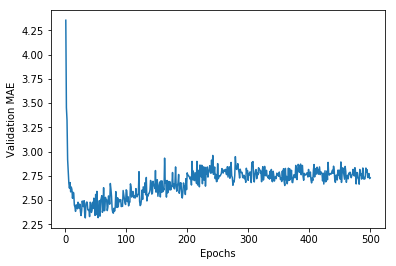

In [12]:
# 3-30 繪製驗證分數

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


因為縱軸的範圍廣大，加上數據方差相對較大，所以難以看清楚這張圖的規律，我們來重新繪製前一張圖，更動如下：
* 刪除前10個數據點，因為他們的取值範圍與曲線上的其他點不同。
* 將每個數據點替換為前面數據點的指數移動平均值，已得到光滑的曲線。<br>
結果如下所示。


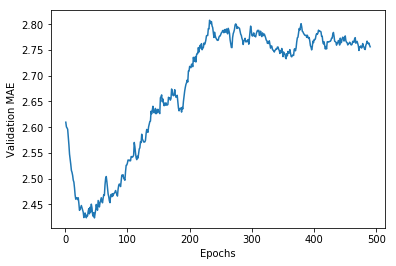

In [13]:
# 3-31 繪製驗證分數( 刪除前10個數據點 )

%matplotlib inline 
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [ ]:
# 3-32 訓練最終模型
model = build_model()               # 一個全新、編譯好的模型
model.fit(train_data,train_targets, # 在所有訓練數據上訓練模型
          epochs=80, batch_size=16,
          verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)    #在全新，未見過的資料集上測試該模型的泛化程度
print(test_mae_score)               # 列出預測房價與真實房價之差別


### 3.6.5 小結
下面是我們應該從此例中學習到的要點。<br>
* 回歸問題與分類問題使用不同的損失函數，分別為MSE與crossentropy。
* 同樣，回歸問題與分類問題使用的評估指標亦不相同，準確度的概念不適用於回歸問題，而MAE才是較適合的替代者。
* 如果輸入數據的特徵具有不同的取值範圍，應該先進行預處理，對每個特徵單獨進行縮放，即進行標準化動作。
* 如果可用的數據很少，使用K折交叉驗證可以有策略地進行評估模型。
* 如果可用的訓練數據很少，最好使用隱藏層較少的小型網路，以避免嚴重的過擬合問題。
